# AWAKEN Neutral turbine: FLORIS Empirical Gaussian

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import floris.tools.visualization as wakeviz
from floris.tools import FlorisInterface
from floris.tools.visualization import (
    calculate_horizontal_plane_with_turbines,
    visualize_cut_plane,
)

import matplotlib.tri as mtri
import pickle

In [2]:
def rotorAvg(y, z, U, y0, zHH, turbD):
    turbR = 0.5*turbD
    mask = ((y-y0)**2 + (z-zHH)**2) <= turbR**2
    inside = U*0
    inside[mask] = 1
    Ninside = np.sum(inside)
    Uavg = np.sum(U*inside)/Ninside
    return Uavg, inside

In [3]:
# Switch to the examples directory to load needed files for the example
#os.chdir('/projects/wind_uq/lcheung/FLORIS/floris/examples')

In [4]:
# Initialize FLORIS with the given input file via FlorisInterface.
# For basic usage, FlorisInterface provides a simplified and expressive
# entry point to the simulation routines.
fi = FlorisInterface("emgauss_GE.yaml")

writeoutputs = True  # Set to true to save results to data files
datadir= 'data/'

rotorD = 127
zHH    = 90
WS     = 6.265
WDir   = 265.6718

sep_dist  = 1.5*rotorD
sep_angle = 0.0

turb1x, turb1y  =  0, 0

# Convert to a simple two turbine layout
#fi.reinitialize(layout_x=[0.0, 0.0], layout_y=[-1.5*rotorD*0.5, 1.5*rotorD*0.5])
fi.reinitialize(layout_x=[turb1x], layout_y=[turb1y])

# Get the turbine powers assuming 1 wind speed and 1 wind direction
fi.reinitialize(wind_directions=[WDir], wind_speeds=[WS])

fi.calculate_wake()

In [5]:
# Using the FlorisInterface functions, get 2D slices.
Nx = 500
Ny = 500
horizontal_plane = fi.calculate_horizontal_plane(
    x_resolution=Nx,
    y_resolution=Ny,
    height=zHH,
    x_bounds=(-600, 2600),
    y_bounds=(-700, 700),
    yaw_angles=np.array([[[0.]]]),
)

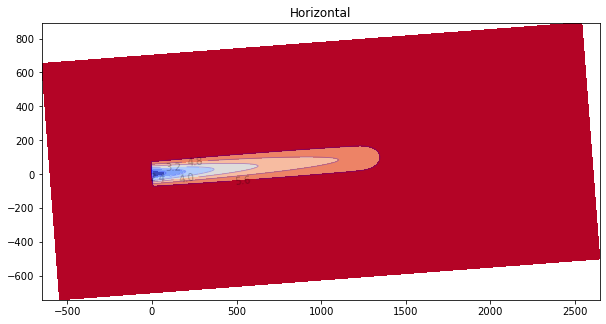

In [6]:
## Create the plots
fig, ax_list = plt.subplots(1, 1, figsize=(10, 8))
#ax_list = ax_list.flatten()
wakeviz.visualize_cut_plane(horizontal_plane, ax=ax_list, title="Horizontal")

(-508.0, 508.0)

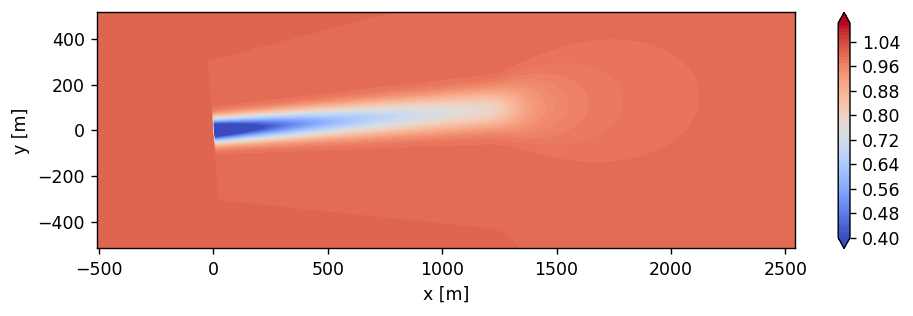

In [7]:
fig, ax_list = plt.subplots(1, 1, figsize=(9, 2.5), dpi=125)
cut_plane = horizontal_plane
xm = cut_plane.df.x1
ym = cut_plane.df.x2
um = cut_plane.df.u
vm = cut_plane.df.v
wm = cut_plane.df.w
im0=plt.tricontourf(xm, ym, um/WS,levels=np.linspace(0.4, 1.1, 71), cmap='coolwarm', extend='both')
plt.colorbar(im0, ax=ax_list)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.xlim([-4*rotorD, 20*rotorD])
plt.ylim([-4*rotorD, 4*rotorD])

In [8]:
# Interpolate to a regular grid
triang = mtri.Triangulation(xm, ym)
xv     = np.arange(-4*rotorD, 20*rotorD+0.1, rotorD/10)
yv     = np.arange(-4*rotorD, 4*rotorD+0.1, 0.05*rotorD)
xi, yi = np.meshgrid(xv, yv)

uinterp_lin = mtri.LinearTriInterpolator(triang, um)
um_interp = uinterp_lin(xi, yi)

vinterp_lin = mtri.LinearTriInterpolator(triang, vm)
vm_interp = vinterp_lin(xi, yi)

winterp_lin = mtri.LinearTriInterpolator(triang, wm)
wm_interp = winterp_lin(xi, yi)


(-508.0, 508.0)

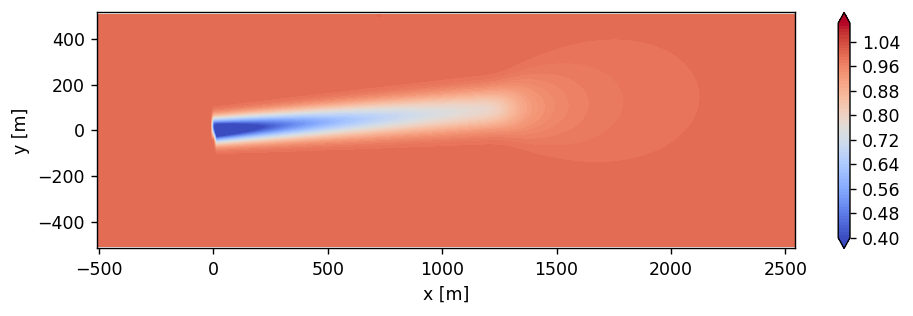

In [9]:
fig, ax_list = plt.subplots(1, 1, figsize=(9, 2.5), dpi=125)
im0=plt.contourf(xi, yi, um_interp/WS,levels=np.linspace(0.4, 1.1, 71), cmap='coolwarm', extend='both')
plt.colorbar(im0)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.xlim([-4*rotorD, 20*rotorD])
plt.ylim([-4*rotorD, 4*rotorD])

(-300.0, 300.0)

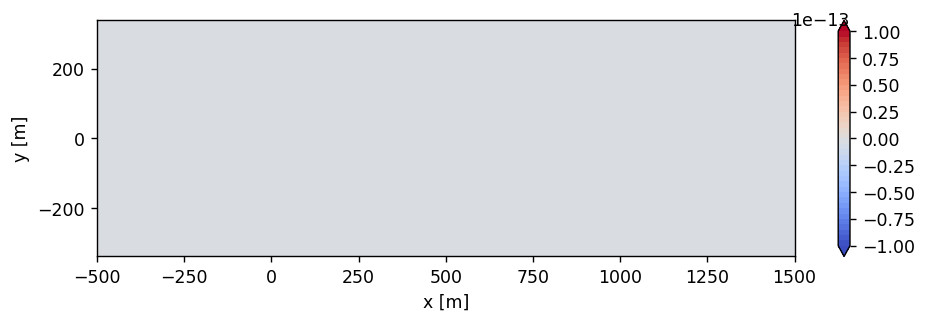

In [10]:
fig, ax_list = plt.subplots(1, 1, figsize=(9, 2.5), dpi=125)
im0=plt.contourf(xi, yi, vm_interp,levels=41, cmap='coolwarm', extend='both')
plt.colorbar(im0)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.xlim([-500, 1500])
plt.ylim([-300, 300])

In [11]:
# write the pickle file
if writeoutputs:
    dbfile = open('pklfiles/FLORIS_HH_avgVEL.pkl', 'wb')
    pickle.dump({'X':xi, 
                 'Y':yi, 
                 'U':um_interp, 
                 'V':vm_interp, 
                 'W':wm_interp, }, dbfile, protocol=2)
    dbfile.close()

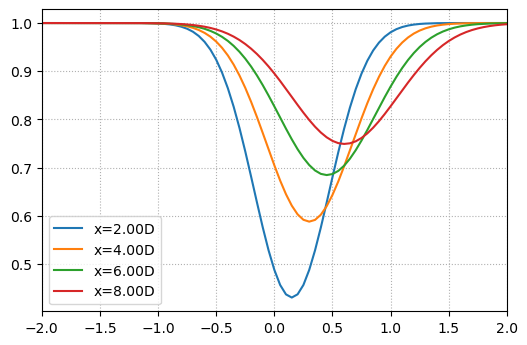

In [12]:
xvec = xv #xm[0,:]
yvec = yv #ym[:,0]
xtarget = [2, 4, 6, 8] #[2.5, 5.0, 10]

plt.figure(figsize=(6,4), dpi=100)
for x in xtarget:
    idx = np.abs(xvec - x*rotorD).argmin()
    xD = xvec[idx]/rotorD
    plt.plot(yvec/rotorD, um_interp[:,idx]/WS, label=f'x={xD:0.2f}D')
    plt.xlim([-2, 2])
    plt.grid(ls=':')
    
plt.legend()

In [13]:
vm = cut_plane.df.v
vinterp_lin = mtri.LinearTriInterpolator(triang, vm)
vm_interp = vinterp_lin(xi, yi)

xtarget = np.arange(-2,21,1)

if writeoutputs:
    for x in xtarget:
        idx = np.abs(xvec - x*rotorD).argmin()
        xD = xvec[idx]/rotorD
        savedat = np.vstack((yvec/rotorD, um_interp[:,idx], vm_interp[:,idx]))
        fname   = f'FLORIS_HH_VEL_PROFILE_x_{xD:06.2f}D.dat'
        np.savetxt(datadir+'/'+fname, savedat.transpose(), header="Y/D U V")

In [14]:
# Print turbine powers
turbine_powers = fi.get_turbine_powers()/1000.
print(turbine_powers)

[[[707.91058708]]]
